# Sistema de Recomendação

Este notebook apresenta algumas implementações de sistema de recomendação utilizando
o dataset Movielens.
Este notebook utiliza dois modelos:
 1. Modelo de Sistema de Recomendação utilizando atributos latentes e produto interno
 2. Modelo utilizando atributos latentes concatenados e uma rede neural
 
Para o modelo 2:
- Calcula a predição para todos os filmes e usuários que não fizeram suas avaliações
- Visualiza a matriz de avaliações por usuários x filmes com todas as predições
- Análise do significado dos embeddings

Obs: Este notebook foi inspirado em exemplo divulgado pelo curso online disponível em [fast.ai](http://fast.ai)

## Importação da bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import os, sys
import pandas as pd

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


### Leitura dos Dados - Movielens dataset

Caso a célula a seguir falhar, é necessário executar o notebook:
- [Movielens Dataset](MovieLens_dataset_pytorch.ipynb) que é responsável por ler o dataset original e
prepará-lo para este notebook

Este dataset consiste de:
- 100.004 avaliações de filmes (amostras), feitas por
- 671 usuários, sobre
- 9066 filmes

As amostras estão no array `ratings` organizados da seguinte forma:
- cada linha é uma amostra
- coluna 0 é o iD do usuário
- coluna 1 é o iD do filme
- coluna 2 é a avaliação do usuários entre 0.0 e 5.0

In [4]:
data = np.load('../data/movielens_norm.npz')
ratings     = data['ratings']
movie_names = data['movie_names']
n_samples   = ratings.shape[0]
print('n_samples:',n_samples)
print('ratings:\n', ratings[:5])

n_samples: 100004
ratings:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


In [5]:
for i in (ratings[:5,1]).astype(np.int):
    print(movie_names[i])

Dangerous Minds (1995)
Dumbo (1941)
Sleepers (1996)
Escape from New York (1981)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [6]:
h_userId  = np.bincount(ratings[:,0].astype(np.int))
n_users   = h_userId.size
h_movieId = np.bincount(ratings[:,1].astype(np.int))
n_movies  = h_movieId.size
print('n_users:',n_users)
print('n_movies:',n_movies)

n_users: 671
n_movies: 9066


## Divisão dos dados em treinamento e validação

In [7]:
np.random.seed = 42

Faz a divisão com 80% das amostras para treinamento e 20% para validação:

In [8]:
msk = np.random.rand(n_samples) < 0.8
train = ratings[msk]
valid = ratings[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 80015  amostras:
 [[ 0.0  833.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]
 [ 0.0  1017.0  2.0]
 [ 0.0  1041.0  2.0]]
valid: 19989  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  859.0  3.0]
 [ 0.0  1083.0  3.5]
 [ 0.0  1140.0  1.0]
 [ 0.0  1515.0  4.0]]


`userId` e `movieId` precisam ser inteiros pois são entradas do *Embedding*:

In [9]:
train_userId  = torch.LongTensor(train[:,0].astype(np.int))
train_movieId = torch.LongTensor(train[:,1].astype(np.int))
train_ratings = torch.FloatTensor(train[:,2:3]) # importante que fique bidimensional
valid_userId  = torch.LongTensor(valid[:,0].astype(np.int))
valid_movieId = torch.LongTensor(valid[:,1].astype(np.int))
valid_ratings = torch.FloatTensor(valid[:,2:3]) # importante que fique bidimensional

## Definição da classe MLDataset

In [10]:
from torch.utils.data import Dataset
class MLDataset(Dataset):
    
    def __init__(self, data_user, data_movie, target):
        assert data_user.size(0)  == target.size(0) and \
               data_movie.size(0) == target.size(0)
        
        self.data   = torch.transpose(torch.stack( (data_user, data_movie) ),0,1)
        self.target = target
    
    def __len__(self):
        return self.target.size(0)
    
    def __getitem__(self, i):
        return (self.data[i], self.target[i])

### Criação dos objetos datasets e dataloaders

In [11]:
datasets = {
    'train': MLDataset(train_userId, train_movieId, train_ratings),
    'val'  : MLDataset(valid_userId, valid_movieId, valid_ratings)
    }

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=64, shuffle=True),
    'val'  : torch.utils.data.DataLoader(datasets['val'],   batch_size=64, shuffle=True)
    }

dataset_sizes = {
    'train': len(datasets['train']),
    'val'  : len(datasets['val'])
    }

print(dataset_sizes)

{'train': 80015, 'val': 19989}


### Testando os datasets

In [12]:
x, y = datasets['train'][3:5]
print(x)
print(y)


    0  1017
    0  1041
[torch.LongTensor of size 2x2]


 2
 2
[torch.FloatTensor of size 2x1]



### Testando os dataloaders

In [13]:
batch_size = 64
print( len(dataloaders['val']) * batch_size ) # verificando mini-batches
for k,data in enumerate(dataloaders['val']):
    print(k, len(data[0]), len(data[1]))
    if k > 1: break

20032
0 64 64
1 64 64
2 64 64


## Primeira solução - usando produto interno: Dot

<img src='../figures/Recomendacao_dot.png', width=600ptx></img>

O primeiro modelo é o produto interno entre os atributos latentes dos usuários e dos filmes.
Este produto interno é implementado pelo produto elemento por elemento das matrizes
de atributos dos usuários e dos filmes e posteriormente somado, resultado um valor escalar por amostra:

In [14]:
class DotNet(nn.Module):
    def __init__(self, n_users, n_movies, n_attributes):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes.
        """
        super(DotNet, self).__init__()
        self.user_emb  = nn.Embedding(n_users, n_attributes)
        nn.init.xavier_uniform(self.user_emb.weight)
        self.movie_emb = nn.Embedding(n_movies, n_attributes)
        nn.init.xavier_uniform(self.movie_emb.weight)

    def forward(self, x):
        """
        x: (user_id, movie_id)
        """
        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        y_pred = (user_attr * movie_attr).sum(1)
        return y_pred


### Instanciando a rede

Utilizando o tamanho do embedding como 50. São 50 atributos, tanto para cada filme como para cada usuário.

In [15]:
n_factors = 50
model_dot = DotNet(n_users, n_movies, n_factors)
if use_gpu:
    model_dot.cuda()
model_dot

DotNet (
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
)

### Treinando a rede

In [16]:
optimizer = torch.optim.Adam(model_dot.parameters())
savebest  = ptt.ModelCheckpoint('../../models/Recomendacao_dot', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
    model         = model_dot, 
    criterion     = nn.MSELoss(), 
    optimizer     = torch.optim.Adam(model_dot.parameters()), 
    callbacks     = [savebest, ptt.PrintCallback()]
                     )

In [17]:
trainer.fit_loader(n_epochs=8, train_data=dataloaders['train'], valid_data=dataloaders['val'])

Start training for 8 epochs
  1:  15.0s   T: 10.81623   V: 4.38907 best
  2:  21.0s   T: 2.44605   V: 1.82928 best
  3:  21.0s   T: 1.22921   V: 1.42743 best
  4:  21.1s   T: 0.90250   V: 1.30327 best
  5:  21.2s   T: 0.74744   V: 1.25522 best
  6:  22.3s   T: 0.64766   V: 1.23590 best
  7:  21.9s   T: 0.57162   V: 1.22942 best
  8:  24.0s   T: 0.50815   V: 1.23343 
Best model was saved at epoch 7 with loss 1.22942: ../../models/Recomendacao_dot
Stop training at epoch: 8/8


### Avaliando a rede

Ultima loss: 1.2334261979853518


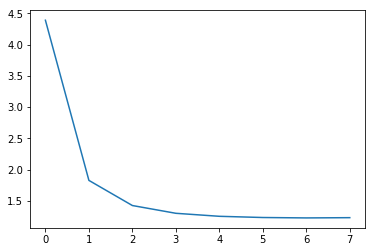

In [18]:
plt.plot(trainer.metrics['valid']['losses'])
print('Ultima loss:', trainer.metrics['valid']['losses'][-1])

Os bons modelos [best benchmarks](http://www.librec.net/example.html) são próximos de 0.9, há necessidade de melhorias.

### Predição de usuário e filme

Para calcular qualquer predição de qualquer usuário e qualquer filme, usa-se o `predict` do modelo treinado:

In [19]:
# user_id: 3 e movie_id: 6
trainer.predict(torch.LongTensor([[3, 6]]))


 3.9564
[torch.FloatTensor of size 1]

##  Solução com Rede Neural

Uma solução usando rede neural é concatenar a saída dos embeddings e em seguida colocar uma camada densa
antes da última camada de um neurônio. No exemplo a seguir foi utilizado uma camada de 70 neurônios.

<img src='../figures/Recomendacao_NN.png', width=600ptx></img>

In [54]:
class RecommendNet(nn.Module):
    def __init__(self, n_users, n_movies, n_attributes):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes e duas densas.
        """
        super(RecommendNet, self).__init__()
        self.user_emb  = nn.Embedding(n_users, n_attributes)
        nn.init.xavier_uniform(self.user_emb.weight)
        
        self.movie_emb = nn.Embedding(n_movies, n_attributes)
        nn.init.xavier_uniform(self.movie_emb.weight)
        
        self.drop1  = nn.Dropout(0.3)
        
        self.dense1 = nn.Linear(2*n_attributes, 70)
        nn.init.xavier_uniform(self.dense1.weight, gain=nn.init.calculate_gain('relu'))
        
        self.relu1  = nn.ReLU()
        self.drop2  = nn.Dropout(0.75)
        
        self.dense2 = nn.Linear(70,1)
        nn.init.xavier_uniform(self.dense2.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        """
        x: (user_id, movie_id)
        """
        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        x = torch.cat((user_attr,movie_attr),dim=1)
        x = self.drop1(x)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.drop2(x)
        y_pred = self.dense2(x)
        return y_pred
    
    def get_movie_emb(self, movie_id):
        return self.movie_emb(movie_id)
    

In [55]:
model_net = RecommendNet(n_users, n_movies, n_factors)
if use_gpu:
    model_net = model_net.cuda()
model_net

RecommendNet (
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
  (drop1): Dropout (p = 0.3)
  (dense1): Linear (100 -> 70)
  (relu1): ReLU ()
  (drop2): Dropout (p = 0.75)
  (dense2): Linear (70 -> 1)
)

## Treinando a rede

In [56]:
optimizer = torch.optim.Adam(model_net.parameters())
savebest  = ptt.ModelCheckpoint('../../models/Recomendacao_net', reset=True, verbose=1)

trainer_net = ptt.DeepNetTrainer(
    model         = model_net, 
    criterion     = nn.MSELoss(), 
    optimizer     = torch.optim.Adam(model_net.parameters()), 
    callbacks     = [savebest, ptt.PrintCallback()]
                     )

In [57]:
trainer_net.fit_loader(n_epochs=5, train_data=dataloaders['train'], valid_data=dataloaders['val'])

Start training for 5 epochs
  1:  15.6s   T: 2.65573   V: 0.89171 best
Best model was saved at epoch 1 with loss 0.89171: ../../models/Recomendacao_net
Stop training at epoch: 1/5


### Avaliando a rede

In [28]:
trainer_net.load_state('../../models/Recomendacao_net')
print(trainer_net.metrics['valid']['losses'][-1])

0.9382579984848123


Com esta rede, a perda já é bem melhor, comparável com os melhores sistemas de recomendação.

## Matriz de recomendações, por usuário e por filme

O sistema de recomendação pode ser visualizado por uma matriz onde as linhas sejam os
IDs dos usuários e as colunas sejam os IDs dos títulos dos filmes. Colocamos como -1
os elementos em que não existem avaliações. Esta matriz é bastante esparsa, pois existem
normalmente poucas avaliações feitas.

In [29]:
grid_ratings = -1. * np.ones((n_users,n_movies))
uId = (ratings[:,0]).astype(np.int)
mId = (ratings[:,1]).astype(np.int)
grid_ratings[uId,mId] = ratings[:,2] # Criação da matriz
print(grid_ratings.shape)

(671, 9066)


### Visualização da matriz de recomendações, original

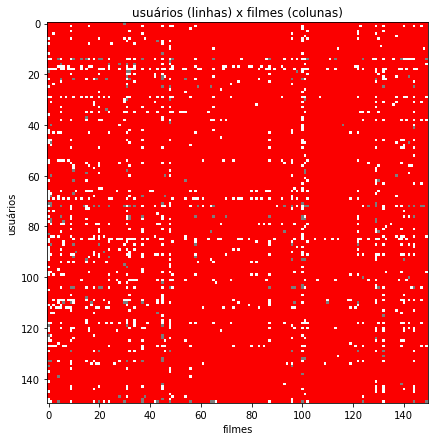

In [30]:
show_ratings = np.zeros((n_users,n_movies,3))
show_ratings[:,:,0] = np.where(grid_ratings == -1., 5, grid_ratings)
show_ratings[:,:,1] = np.where(grid_ratings == -1., 0., grid_ratings)
show_ratings[:,:,2] = np.where(grid_ratings == -1., 0., grid_ratings)


import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(show_ratings[:150,:150,:])
plt.xlabel('filmes')
plt.ylabel('usuários')
plt.show()

## Predições para todos os usuários e filmes

In [31]:
n2p_user,n2p_movie = np.nonzero(grid_ratings==-1)
xin = torch.from_numpy(np.array([n2p_user, n2p_movie]).T)
recommend = trainer_net.predict(xin)

### Montagem da matriz de recomendação "cheia"

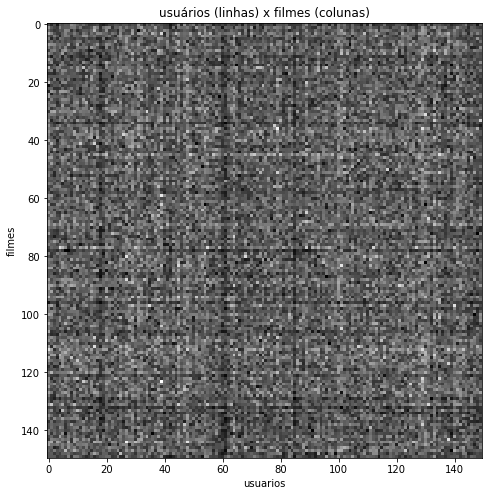

In [32]:
gg = grid_ratings.copy()
gg[n2p_user,n2p_movie] = recommend[:,0].numpy()

plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
plt.xlabel('usuarios')
plt.ylabel('filmes')
plt.imshow(gg[:150,:150],cmap='gray')
plt.show()

### Visualização da parte de usuários mais ativos e filmes mais populares

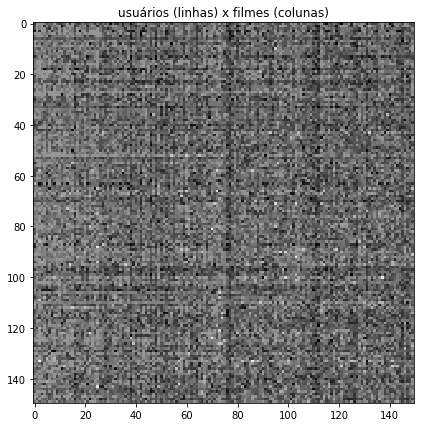

In [33]:
io_popular_movies = np.argsort(h_movieId)[::-1]
io_top_users = np.argsort(h_userId)[::-1].astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[:150,:150],cmap='gray')
plt.show()

### Visualização dos usuários menos ativos e filmes menos avaliados

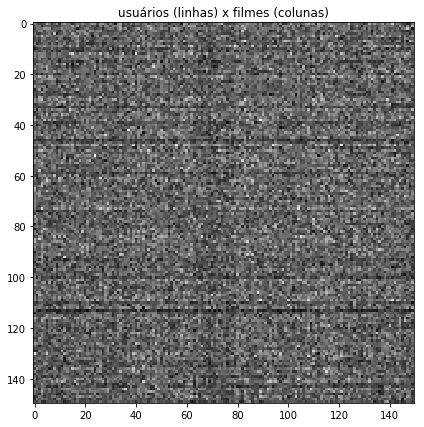

In [34]:
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[-150:,-150:],cmap='gray')
plt.show()

## Analise dos embeddings dos filmes

A análise a seguir será feita apenas com os 2000 filmes mais populares:

In [35]:
topMovies = io_popular_movies[:2000].copy()

### Extração dos atributos latentes (embeddings) dos 2000 fimes mais populares

Para obter os atributos latentes dos 2000 filmes mais populares, aplicamos o `topMovies`
na função get_movie_emb que faz parte do objeto model_net, criado na classe RecommendNet:

In [36]:
xin = torch.unsqueeze(torch.LongTensor(topMovies),1)
m_emb = model_net.get_movie_emb(Variable(xin))
movie_emb = np.squeeze(m_emb.data.numpy()) # elimina dimensões 1
movie_emb.shape

(2000, 50)

Como o embedding de cada filme tem dimensão 50, é muito difícil conseguir analisá-lo desta forma.
Uma forma muito usual é reduzir esta dimensionalidade utilizando uma técnica denominada PCA -
Principal Component Analysis: [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/).
Iremos reduzir a dimensão dos embeddings de 50 para 2. 

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
movie_pca = pca.fit(movie_emb.T).components_

#### Filmes com alto valor na primeira dimensão do PCA

In [38]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

for ii in isort[:15]:
    print(fac0[ii],movie_names[ii])

0.0653916 Othello (1995)
0.0609479 Coup de torchon (Clean Slate) (1981)
0.060205 Double Team (1997)
0.0600972 Grumpier Old Men (1995)
0.0570274 Rising Sun (1993)
0.0546152 Casino (1995)
0.0538206 Cobb (1994)
0.0536697 Sudden Death (1995)
0.0536079 Before and After (1996)
0.0529881 Tomorrow Never Dies (1997)
0.0528569 Madness of King George, The (1994)
0.0515227 Hackers (1995)
0.0513255 Gigi (1958)
0.051255 Tommy Boy (1995)
0.0511606 Mrs. Winterbourne (1996)


#### Filmes com baixo valor na primeira dimensão do PCA

In [39]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[ii])

-0.0363895 Wide Awake (1998)
-0.0389058 Attack of the Killer Tomatoes! (1978)
-0.0389907 Blade (1998)
-0.0399657 Police Academy 4: Citizens on Patrol (1987)
-0.0405161 Back to the Future Part II (1989)
-0.0417986 Governess, The (1998)
-0.0422675 Man Who Knew Too Little, The (1997)
-0.0436745 Star Trek II: The Wrath of Khan (1982)
-0.0442307 Something to Talk About (1995)
-0.0446399 Police Academy 3: Back in Training (1986)
-0.0473543 Game, The (1997)
-0.0489601 Nashville (1975)
-0.0494937 Mulan (1998)
-0.0520862 Wings of the Dove, The (1997)
-0.0573638 Friday the 13th Part VII: The New Blood (1988)


### Análise da segunda dimensão do PCA

In [40]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

#### Mais bem avaliados na segunda dimensão

In [41]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[ii])

0.0717125 Legend (1985)
0.071019 Celebration, The (Festen) (1998)
0.0671361 Life Less Ordinary, A (1997)
0.0667479 Night of the Living Dead (1968)
0.0660521 Vive L'Amour (Ai qing wan sui) (1994)
0.0629198 I Still Know What You Did Last Summer (1998)
0.0603412 Steamboat Willie (1928)
0.0597771 Benny & Joon (1993)
0.0596859 Horse Whisperer, The (1998)
0.0595189 Amazing Panda Adventure, The (1995)
0.0580681 Twin Town (1997)
0.057853 In the Company of Men (1997)
0.0572258 Incredible Journey, The (1963)
0.0570489 Farewell to Arms, A (1932)
0.05669 Jungle Book, The (1994)


#### Piores avaliados na segunda dimensão

In [42]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[ii])

-0.0559443 He Walked by Night (1948)
-0.0563052 Halloween H20: 20 Years Later (Halloween 7: The Revenge of Laurie Strode) (1998)
-0.0563304 Wild Man Blues (1997)
-0.0577864 Fifth Element, The (1997)
-0.0578368 Nightmare Before Christmas, The (1993)
-0.0580681 Beverly Hillbillies, The (1993)
-0.0580865 Ghost and the Darkness, The (1996)
-0.0591932 Scream 2 (1997)
-0.0593288 King Kong (1933)
-0.0605262 Gridlock'd (1997)
-0.0622962 Matilda (1996)
-0.0631059 Hellraiser: Bloodline (1996)
-0.0632472 Six Days Seven Nights (1998)
-0.0647007 The Devil's Advocate (1997)
-0.0771662 Singin' in the Rain (1952)


### Visualizando duas dimensões do PCA

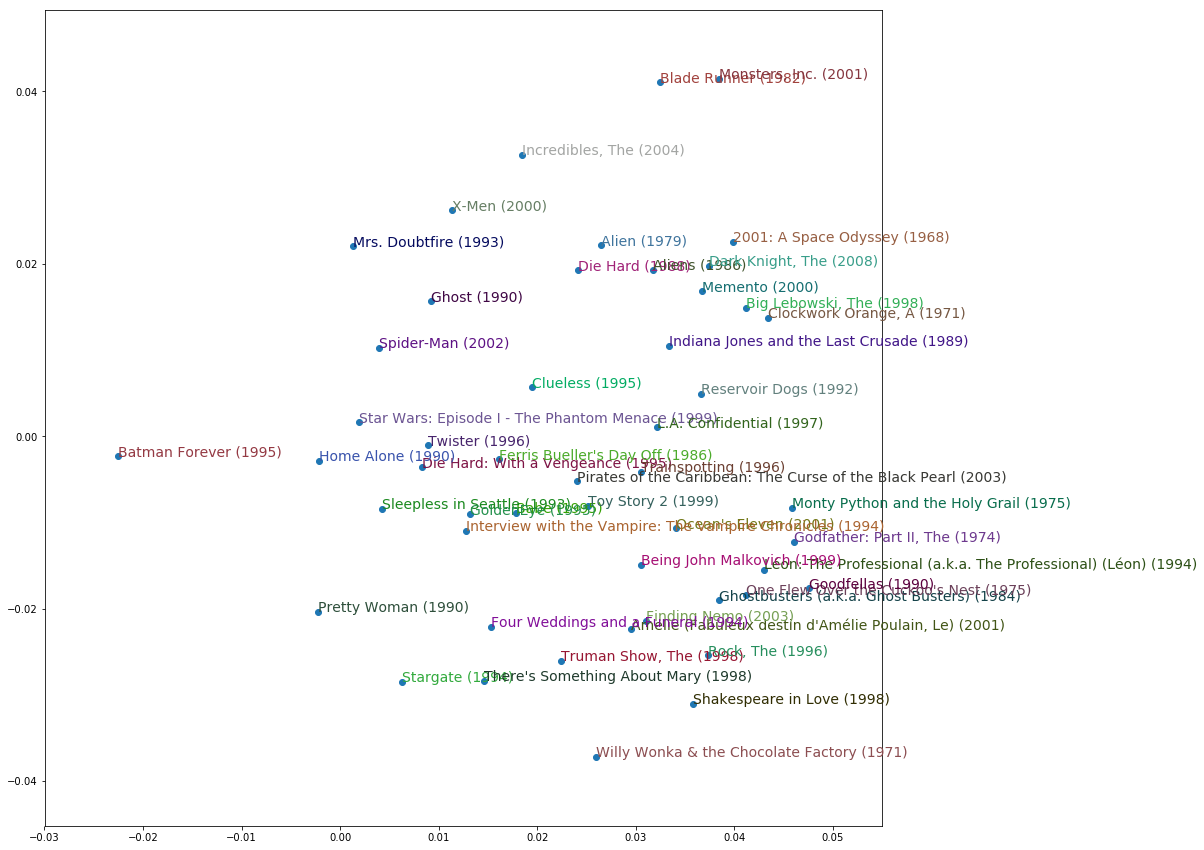

In [43]:
start=50; end=100
X = fac0[start:end]
Y = fac1[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Exercícios

1. Inclua um novo usuário, sem nenhuma avaliação. Treine a rede e verifique
   se após a rede treinada, se haverá alguma avaliação.
2. Com o novo usuário, faça uma única avaliação e verifique quais os 10 filmes
   mais recomendados para ele.

## Aprendizados com este notebook